# An Introduction to Factorization Machines with MNIST


---

This notebook's CI test result for us-west-2 is as follows. CI test results in other regions can be found at the end of the notebook. 

![This us-west-2 badge failed to load. Check your device's internet connectivity, otherwise the service is currently unavailable](https://prod.us-west-2.tcx-beacon.docs.aws.dev/sagemaker-nb/us-west-2/introduction_to_amazon_algorithms|factorization_machines_mnist|factorization_machines_mnist.ipynb)

---

_**Making a Binary Prediction of Whether a Handwritten Digit is a 0**_

1. [Introduction](#Introduction)
2. [Prerequisites and Preprocessing](#Prequisites-and-Preprocessing)
  1. [Permissions and environment variables](#Permissions-and-environment-variables)
  2. [Data ingestion](#Data-ingestion)
  3. [Data inspection](#Data-inspection)
  4. [Data conversion](#Data-conversion)
3. [Training the FM model](#Training-the-FM-model)
4. [Set up hosting for the model](#Set-up-hosting-for-the-model)
  1. [Import model into hosting](#Import-model-into-hosting)
  2. [Create endpoint configuration](#Create-endpoint-configuration)
  3. [Create endpoint](#Create-endpoint)
5. [Validate the model for use](#Validate-the-model-for-use)


## Introduction

Welcome to our example introducing Amazon SageMaker's Factorization Machines Algorithm!  Today, we're analyzing the [MNIST](https://en.wikipedia.org/wiki/MNIST_database) dataset which consists of images of handwritten digits, from zero to nine.  We'll use the individual pixel values from each 28 x 28 grayscale image to predict a yes or no label of whether the digit is a 0 or some other digit (1, 2, 3, ... 9).

The method that we'll use is a factorization machine binary classifier.  A factorization machine is a general-purpose supervised learning algorithm that you can use for both classification and regression tasks.  It is an extension of a linear model that is designed to parsimoniously capture interactions between features in high dimensional sparse datasets.  For example, in a click prediction system, the factorization machine model can capture click rate patterns observed when ads from a certain ad-category are placed on pages from a certain page-category.  Factorization machines are a good choice for tasks dealing with high dimensional sparse datasets, such as click prediction and item recommendation.

Amazon SageMaker's Factorization Machine algorithm provides a robust, highly scalable implementation of this algorithm, which has become extremely popular in ad click prediction and recommender systems.  The main purpose of this notebook is to quickly show the basics of implementing Amazon SageMaker Factorization Machines, even if the use case of predicting a digit from an image is not where factorization machines shine.

To get started, we need to set up the environment with a few prerequisite steps, for permissions, configurations, and so on.

## Prequisites and Preprocessing

### Permissions and environment variables

_This notebook was tested in Amazon SageMaker Studio on a ml.t3.medium instance with Python 3 (Data Science) kernel._

Let's start by specifying:

- The S3 buckets and prefixes that you want to use for training and model data and where the original mnist data is located.  This should be within the same region as the Notebook Instance, training, and hosting.
- The IAM role arn used to give training and hosting access to your data. See the documentation for how to create these.  Note, if more than one role is required for notebook instances, training, and/or hosting, please replace the boto regexp with a the appropriate full IAM role arn string(s).

In [1]:
import re
import boto3
import sagemaker
from sagemaker import get_execution_role
import json

role = get_execution_role()

region = boto3.Session().region_name

# S3 bucket where the original mnist data is downloaded and stored.
downloaded_data_bucket = f"sagemaker-example-files-prod-{region}"
downloaded_data_prefix = "datasets/image/MNIST"

print(role)
sess = sagemaker.Session()

# bucket used for storing processed data and model.
bucket = sess.default_bucket()
prefix = "sagemaker/DEMO-fm-mnist"
print(bucket)

/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/pydantic/_internal/_fields.py:192: UserWarning: Field name "json" in "MonitoringDatasetFormat" shadows an attribute in parent "Base"
  warnings.warn(


[03/17/25 19:31:58] INFO     Found credentials from IAM Role:                                   ]8;id=742899;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/botocore/credentials.py\credentials.py]8;;\:]8;id=331475;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/botocore/credentials.py#1132\1132]8;;\
                             BaseNotebookInstanceEc2InstanceRole                                                   

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/ec2-user/.config/sagemaker/config.yaml


                    INFO     Found credentials from IAM Role:                                   ]8;id=851541;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/botocore/credentials.py\credentials.py]8;;\:]8;id=531505;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/botocore/credentials.py#1132\1132]8;;\
                             BaseNotebookInstanceEc2InstanceRole                                                   

arn:aws:iam::160885266928:role/service-role/AmazonSageMakerServiceCatalogProductsUseRole


[03/17/25 19:31:59] INFO     Found credentials from IAM Role:                                   ]8;id=491696;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/botocore/credentials.py\credentials.py]8;;\:]8;id=975072;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/botocore/credentials.py#1132\1132]8;;\
                             BaseNotebookInstanceEc2InstanceRole                                                   

sagemaker-us-east-2-160885266928


### Data ingestion

Next, we read the MNIST dataset [1] from an existing repository for preprocessing prior to training. It was downloaded from [here](http://deeplearning.net/data/mnist/mnist.pkl.gz). The processing could be done *in situ* by Amazon Athena, Apache Spark in Amazon EMR, Amazon Redshift, etc., assuming the dataset is present in the appropriate location. Then, the next step would be to transfer the data to S3 for use in training. For small datasets, such as this one, reading into memory isn't onerous, though it would be for larger datasets.

> [1] Y. LeCun, L. Bottou, Y. Bengio, and P. Haffner. Gradient-based learning applied to document recognition. Proceedings of the IEEE, 86(11):2278-2324, November 1998.

In [2]:
%%time
import pickle, gzip, numpy, json
import boto3

# Load the dataset
s3 = boto3.client("s3")
s3.download_file(downloaded_data_bucket, f"{downloaded_data_prefix}/mnist.pkl.gz", "mnist.pkl.gz")
with gzip.open("mnist.pkl.gz", "rb") as f:
    train_set, valid_set, test_set = pickle.load(f, encoding="latin1")

[03/17/25 19:32:03] INFO     Found credentials from IAM Role:                                   ]8;id=828158;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/botocore/credentials.py\credentials.py]8;;\:]8;id=435170;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/botocore/credentials.py#1132\1132]8;;\
                             BaseNotebookInstanceEc2InstanceRole                                                   

CPU times: user 988 ms, sys: 359 ms, total: 1.35 s
Wall time: 1.88 s


### Data inspection

Once the dataset is imported, it's typical as part of the machine learning process to inspect the data, understand the distributions, and determine what type(s) of preprocessing might be needed. You can perform those tasks right here in the notebook. As an example, let's go ahead and look at one of the digits that is part of the dataset.

[03/17/25 19:32:16] WARNING  Matplotlib is building the font cache; this may take a moment.    ]8;id=452798;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/matplotlib/font_manager.py\font_manager.py]8;;\:]8;id=851215;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/matplotlib/font_manager.py#1095\1095]8;;\

                    INFO     generated new fontManager                                         ]8;id=50853;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/matplotlib/font_manager.py\font_manager.py]8;;\:]8;id=101884;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/matplotlib/font_manager.py#1639\1639]8;;\

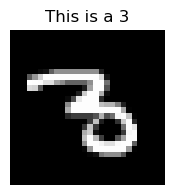

In [3]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.rcParams["figure.figsize"] = (2, 10)


def show_digit(img, caption="", subplot=None):
    if subplot is None:
        _, (subplot) = plt.subplots(1, 1)
    imgr = img.reshape((28, 28))
    subplot.axis("off")
    subplot.imshow(imgr, cmap="gray")
    plt.title(caption)


show_digit(train_set[0][30], f"This is a {train_set[1][30]}")

### Data conversion

Since algorithms have particular input and output requirements, converting the dataset is also part of the process that a data scientist goes through prior to initiating training. In this particular case, the Amazon SageMaker implementation of Factorization Machines takes recordIO-wrapped protobuf, where the data we have today is a pickle-ized numpy array on disk.

Most of the conversion effort is handled by the Amazon SageMaker Python SDK, imported as `sagemaker` below.

_Notice, despite the fact that most use cases for factorization machines will utilize spare input, we are writing our data out as dense tensors.  This will be fine since the MNIST dataset is not particularly large or high dimensional._

In [4]:
import io
import numpy as np
import sagemaker.amazon.common as smac

vectors = np.array([t.tolist() for t in train_set[0]]).astype("float32")
labels = np.where(np.array([t.tolist() for t in train_set[1]]) == 0, 1.0, 0.0).astype("float32")

buf = io.BytesIO()
smac.write_numpy_to_dense_tensor(buf, vectors, labels)
buf.seek(0)

0

## Upload training data
Now that we've created our recordIO-wrapped protobuf, we'll need to upload it to S3, so that Amazon SageMaker training can use it.

In [5]:
import boto3
import os

key = "recordio-pb-data"
boto3.resource("s3").Bucket(bucket).Object(os.path.join(prefix, "train", key)).upload_fileobj(buf)
s3_train_data = f"s3://{bucket}/{prefix}/train/{key}"
print(f"uploaded training data location: {s3_train_data}")

uploaded training data location: s3://sagemaker-us-east-2-160885266928/sagemaker/DEMO-fm-mnist/train/recordio-pb-data


Let's also setup an output S3 location for the model artifact that will be output as the result of training with the algorithm.

In [6]:
output_location = f"s3://{bucket}/{prefix}/output"
print(f"training artifacts will be uploaded to: {output_location}")

training artifacts will be uploaded to: s3://sagemaker-us-east-2-160885266928/sagemaker/DEMO-fm-mnist/output


## Training the factorization machine model

Once we have the data preprocessed and available in the correct format for training, the next step is to actually train the model using the data. Since this data is relatively small, it isn't meant to show off the performance of the Amazon SageMaker's Factorization Machines in training, although we have tested it on multi-terabyte datasets.

Again, we'll use the Amazon SageMaker Python SDK to kick off training and monitor status until it is completed.  In this example that takes between 7 and 11 minutes.  Despite the dataset being small, provisioning hardware and loading the algorithm container take time upfront.

First, let's specify our containers.  Since we want this notebook to run in all 4 of Amazon SageMaker's regions, we'll create a small lookup.  More details on algorithm containers can be found in [AWS documentation](https://docs-aws.amazon.com/sagemaker/latest/dg/sagemaker-algo-docker-registry-paths.html).

In [7]:
from sagemaker.amazon.amazon_estimator import get_image_uri

container = get_image_uri(boto3.Session().region_name, "factorization-machines")

[03/17/25 19:32:57] WARNING  The method get_image_uri has been renamed in sagemaker>=2.          ]8;id=665965;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/deprecations.py\deprecations.py]8;;\:]8;id=75962;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/deprecations.py#34\34]8;;\
                             See: https://sagemaker.readthedocs.io/en/stable/v2.html for                           
                             details.                                                                              

                    INFO     Same images used for training and inference. Defaulting to image     ]8;id=180966;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/image_uris.py\image_uris.py]8;;\:]8;id=68153;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/image_uris.py#393\393]8;;\
                             scope: inference.                                                                     

                    INFO     Ignoring unnecessary instance type: None.                            ]8;id=570251;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/image_uris.py\image_uris.py]8;;\:]8;id=234909;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/image_uris.py#530\530]8;;\

Next we'll kick off the base estimator, making sure to pass in the necessary hyperparameters.  Notice:
- `feature_dim` is set to 784, which is the number of pixels in each 28 x 28 image.
- `predictor_type` is set to 'binary_classifier' since we are trying to predict whether the image is or is not a 0.
- `mini_batch_size` is set to 200.  This value can be tuned for relatively minor improvements in fit and speed, but selecting a reasonable value relative to the dataset is appropriate in most cases.
- `num_factors` is set to 10.  As mentioned initially, factorization machines find a lower dimensional representation of the interactions for all features.  Making this value smaller provides a more parsimonious model, closer to a linear model, but may sacrifice information about interactions.  Making it larger provides a higher-dimensional representation of feature interactions, but adds computational complexity and can lead to overfitting.  In a practical application, time should be invested to tune this parameter to the appropriate value.

In [8]:
import boto3
import sagemaker

sess = sagemaker.Session()

fm = sagemaker.estimator.Estimator(
    container,
    role,
    instance_count=1,
    instance_type="ml.c5.xlarge",
    output_path=output_location,
    sagemaker_session=sess,
)
fm.set_hyperparameters(
    feature_dim=784, predictor_type="binary_classifier", mini_batch_size=200, num_factors=10
)

fm.fit({"train": s3_train_data})

[03/17/25 19:33:01] INFO     SageMaker Python SDK will collect telemetry to help us better  ]8;id=569159;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/telemetry/telemetry_logging.py\telemetry_logging.py]8;;\:]8;id=300878;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/telemetry/telemetry_logging.py#91\91]8;;\
                             understand our user's needs, diagnose issues, and deliver                             
                             additional features.                                                                  
                             To opt out of telemetry, please disable via TelemetryOptOut                           
                             parameter in SDK defaults config. For more information, refer                         
                             to                                                                                    
                             https://sagemaker.readthedocs.io/en/stable/overview.html#confi                        
                             guring-and-using-defaults-with-the-sagemaker-python-sdk.                              

                    INFO     Creating training-job with name:                                       ]8;id=183753;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/session.py\session.py]8;;\:]8;id=115059;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/session.py#1042\1042]8;;\
                             factorization-machines-2025-03-17-19-33-01-009                                        

2025-03-17 19:33:02 Starting - Starting the training job...
..25-03-17 19:33:34 Downloading - Downloading input data.
.............Docker entrypoint called with argument(s): train
Running default environment configuration script
/opt/amazon/lib/python3.8/site-packages/mxnet/model.py:97: SyntaxWarning: "is" with a literal. Did you mean "=="?
  if num_device is 1 and 'dist' not in kvstore:
[03/17/2025 19:36:18 INFO 140259600029504] Reading default configuration from /opt/amazon/lib/python3.8/site-packages/algorithm/resources/default-conf.json: {'epochs': 1, 'mini_batch_size': '1000', 'use_bias': 'true', 'use_linear': 'true', 'bias_lr': '0.1', 'linear_lr': '0.001', 'factors_lr': '0.0001', 'bias_wd': '0.01', 'linear_wd': '0.001', 'factors_wd': '0.00001', 'bias_init_method': 'normal', 'bias_init_sigma': '0.01', 'linear_init_method': 'normal', 'linear_init_sigma': '0.01', 'factors_init_method': 'normal', 'factors_init_sigma': '0.001', 'batch_metrics_publish_interval': '500', '_data_format': 

## Set up hosting for the model
Now that we've trained our model, we can deploy it behind an Amazon SageMaker real-time hosted endpoint.  This will allow out to make predictions (or inference) from the model dyanamically.

_Note, Amazon SageMaker allows you the flexibility of importing models trained elsewhere, as well as the choice of not importing models if the target of model creation is AWS Lambda, AWS Greengrass, Amazon Redshift, Amazon Athena, or other deployment target._

In [9]:
fm_predictor = fm.deploy(initial_instance_count=1, instance_type="ml.m5.xlarge")

[03/17/25 19:40:36] INFO     Creating model with name:                                              ]8;id=427215;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/session.py\session.py]8;;\:]8;id=900116;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/session.py#4094\4094]8;;\
                             factorization-machines-2025-03-17-19-40-36-230                                        

                    INFO     Creating endpoint-config with name                                     ]8;id=522133;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/session.py\session.py]8;;\:]8;id=154793;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/session.py#5937\5937]8;;\
                             factorization-machines-2025-03-17-19-40-36-230                                        

[03/17/25 19:40:37] INFO     Creating endpoint with name                                            ]8;id=696384;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/session.py\session.py]8;;\:]8;id=52343;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/session.py#4759\4759]8;;\
                             factorization-machines-2025-03-17-19-40-36-230                                        

-----------!

## Validate the model for use
Finally, we can now validate the model for use.  We can pass HTTP POST requests to the endpoint to get back predictions.  To make this easier, we'll again use the Amazon SageMaker Python SDK and specify how to serialize requests and deserialize responses that are specific to the algorithm.

Since factorization machines are so frequently used with sparse data, making inference requests with a CSV format (as is done in other algorithm examples) can be massively inefficient.  Rather than waste space and time generating all of those zeros, to pad the row to the correct dimensionality, JSON can be used more efficiently.  Since we trained the model using dense data, this is a bit of a moot point, as we'll have to pass all the 0s in anyway.

Nevertheless, we'll write our own small function to serialize our inference request in the JSON format that Amazon SageMaker Factorization Machines expects.

In [10]:
import json
from sagemaker.serializers import JSONSerializer
from sagemaker.deserializers import JSONDeserializer


class FMSerializer(JSONSerializer):
    def serialize(self, data):
        js = {"instances": []}
        for row in data:
            js["instances"].append({"features": row.tolist()})
        return json.dumps(js)


fm_predictor.serializer = FMSerializer()
fm_predictor.deserializer = JSONDeserializer()

Now let's try getting a prediction for a single record.

In [11]:
result = fm_predictor.predict(train_set[0][30:31], initial_args={"ContentType": "application/json"})
print(result)

{'predictions': [{'score': 0.0, 'predicted_label': 0.0}]}


OK, a single prediction works.  We see that for one record our endpoint returned some JSON which contains `predictions`, including the `score` and `predicted_label`.  In this case, `score` will be a continuous value between [0, 1] representing the probability we think the digit is a 0 or not.  `predicted_label` will take a value of either `0` or `1` where (somewhat counterintuitively) `1` denotes that we predict the image is a 0, while `0` denotes that we are predicting the image is not of a 0.

Let's do a whole batch of images and evaluate our predictive accuracy.

In [12]:
import numpy as np

predictions = []
for array in np.array_split(test_set[0], 100):
    result = fm_predictor.predict(array, initial_args={"ContentType": "application/json"})
    predictions += [r["predicted_label"] for r in result["predictions"]]

predictions = np.array(predictions)

In [13]:
import pandas as pd

pd.crosstab(
    np.where(test_set[1] == 0, 1, 0), predictions, rownames=["actuals"], colnames=["predictions"]
)

predictions,0.0,1.0
actuals,,
0,8906,114
1,37,943


As we can see from the confusion matrix above, we predict 951 images of the digit 0 correctly (confusingly this is class 1).  Meanwhile we predict 165 images as the digit 0 when in actuality they aren't, and we miss predicting 29 images of the digit 0 that we should have.

*Note: Due to some differences in parameter initialization, your results may differ from those listed above, but should remain reasonably consistent.*

### (Optional) Delete the Endpoint

If you're ready to be done with this notebook, please run the delete_endpoint line in the cell below.  This will remove the hosted endpoint you created and avoid any charges from a stray instance being left on.

In [14]:
import sagemaker

sagemaker.Session().delete_endpoint(fm_predictor.endpoint)

[03/17/25 19:47:19] WARNING  The endpoint attribute has been renamed in sagemaker>=2.            ]8;id=884529;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/deprecations.py\deprecations.py]8;;\:]8;id=896377;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/deprecations.py#34\34]8;;\
                             See: https://sagemaker.readthedocs.io/en/stable/v2.html for                           
                             details.                                                                              

                    INFO     Deleting endpoint with name:                                           ]8;id=537914;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/session.py\session.py]8;;\:]8;id=337140;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/session.py#4903\4903]8;;\
                             factorization-machines-2025-03-17-19-40-36-230                                        

## Notebook CI Test Results

This notebook was tested in multiple regions. The test results are as follows, except for us-west-2 which is shown at the top of the notebook.

![This us-east-1 badge failed to load. Check your device's internet connectivity, otherwise the service is currently unavailable](https://prod.us-west-2.tcx-beacon.docs.aws.dev/sagemaker-nb/us-east-1/introduction_to_amazon_algorithms|factorization_machines_mnist|factorization_machines_mnist.ipynb)

![This us-east-2 badge failed to load. Check your device's internet connectivity, otherwise the service is currently unavailable](https://prod.us-west-2.tcx-beacon.docs.aws.dev/sagemaker-nb/us-east-2/introduction_to_amazon_algorithms|factorization_machines_mnist|factorization_machines_mnist.ipynb)

![This us-west-1 badge failed to load. Check your device's internet connectivity, otherwise the service is currently unavailable](https://prod.us-west-2.tcx-beacon.docs.aws.dev/sagemaker-nb/us-west-1/introduction_to_amazon_algorithms|factorization_machines_mnist|factorization_machines_mnist.ipynb)

![This ca-central-1 badge failed to load. Check your device's internet connectivity, otherwise the service is currently unavailable](https://prod.us-west-2.tcx-beacon.docs.aws.dev/sagemaker-nb/ca-central-1/introduction_to_amazon_algorithms|factorization_machines_mnist|factorization_machines_mnist.ipynb)

![This sa-east-1 badge failed to load. Check your device's internet connectivity, otherwise the service is currently unavailable](https://prod.us-west-2.tcx-beacon.docs.aws.dev/sagemaker-nb/sa-east-1/introduction_to_amazon_algorithms|factorization_machines_mnist|factorization_machines_mnist.ipynb)

![This eu-west-1 badge failed to load. Check your device's internet connectivity, otherwise the service is currently unavailable](https://prod.us-west-2.tcx-beacon.docs.aws.dev/sagemaker-nb/eu-west-1/introduction_to_amazon_algorithms|factorization_machines_mnist|factorization_machines_mnist.ipynb)

![This eu-west-2 badge failed to load. Check your device's internet connectivity, otherwise the service is currently unavailable](https://prod.us-west-2.tcx-beacon.docs.aws.dev/sagemaker-nb/eu-west-2/introduction_to_amazon_algorithms|factorization_machines_mnist|factorization_machines_mnist.ipynb)

![This eu-west-3 badge failed to load. Check your device's internet connectivity, otherwise the service is currently unavailable](https://prod.us-west-2.tcx-beacon.docs.aws.dev/sagemaker-nb/eu-west-3/introduction_to_amazon_algorithms|factorization_machines_mnist|factorization_machines_mnist.ipynb)

![This eu-central-1 badge failed to load. Check your device's internet connectivity, otherwise the service is currently unavailable](https://prod.us-west-2.tcx-beacon.docs.aws.dev/sagemaker-nb/eu-central-1/introduction_to_amazon_algorithms|factorization_machines_mnist|factorization_machines_mnist.ipynb)

![This eu-north-1 badge failed to load. Check your device's internet connectivity, otherwise the service is currently unavailable](https://prod.us-west-2.tcx-beacon.docs.aws.dev/sagemaker-nb/eu-north-1/introduction_to_amazon_algorithms|factorization_machines_mnist|factorization_machines_mnist.ipynb)

![This ap-southeast-1 badge failed to load. Check your device's internet connectivity, otherwise the service is currently unavailable](https://prod.us-west-2.tcx-beacon.docs.aws.dev/sagemaker-nb/ap-southeast-1/introduction_to_amazon_algorithms|factorization_machines_mnist|factorization_machines_mnist.ipynb)

![This ap-southeast-2 badge failed to load. Check your device's internet connectivity, otherwise the service is currently unavailable](https://prod.us-west-2.tcx-beacon.docs.aws.dev/sagemaker-nb/ap-southeast-2/introduction_to_amazon_algorithms|factorization_machines_mnist|factorization_machines_mnist.ipynb)

![This ap-northeast-1 badge failed to load. Check your device's internet connectivity, otherwise the service is currently unavailable](https://prod.us-west-2.tcx-beacon.docs.aws.dev/sagemaker-nb/ap-northeast-1/introduction_to_amazon_algorithms|factorization_machines_mnist|factorization_machines_mnist.ipynb)

![This ap-northeast-2 badge failed to load. Check your device's internet connectivity, otherwise the service is currently unavailable](https://prod.us-west-2.tcx-beacon.docs.aws.dev/sagemaker-nb/ap-northeast-2/introduction_to_amazon_algorithms|factorization_machines_mnist|factorization_machines_mnist.ipynb)

![This ap-south-1 badge failed to load. Check your device's internet connectivity, otherwise the service is currently unavailable](https://prod.us-west-2.tcx-beacon.docs.aws.dev/sagemaker-nb/ap-south-1/introduction_to_amazon_algorithms|factorization_machines_mnist|factorization_machines_mnist.ipynb)
